<a href="https://colab.research.google.com/github/Haffizuddin7899/-Capstone-Project--Fungal_Disease_Detection_In_Plants_Using_Leaf_Images-/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Mount Google Drive and load data
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Define data directory path
data_dir = '/content/gdrive/MyDrive/Capstone Project/DATA/Color'


In [3]:
# Step 2: Data Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2, # Randomly shift images vertically by up to 20% of height
    shear_range=0.2,        # Shear intensity
    zoom_range=0.2,         # Randomly zoom into images
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill missing pixels using the nearest pixel
)


In [5]:
# Load and augment training data
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # VGG16 input size
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 3171 images belonging to 4 classes.


In [9]:
# Step 3: Manual Data Splitting
import os
import shutil

In [10]:
# Create train, test, and validation directories
split_dir = '/content/gdrive/MyDrive/Capstone Project/DATA/data_split/'
os.makedirs(split_dir + 'train', exist_ok=True)
os.makedirs(split_dir + 'test', exist_ok=True)
os.makedirs(split_dir + 'val', exist_ok=True)

In [11]:
# Define the percentage split
train_split = 0.7
test_split = 0.2
val_split = 0.1

In [12]:
# Iterate through the original data directory and move images to the split directories
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)

    # Create corresponding directories in the split path
    os.makedirs(os.path.join(split_dir, 'train', class_name), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'test', class_name), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'val', class_name), exist_ok=True)

    # List all images in the class directory
    class_images = os.listdir(class_path)
    num_images = len(class_images)

    # Calculate split indices
    train_end = int(train_split * num_images)
    test_end = train_end + int(test_split * num_images)

    # Move images to the appropriate split directory
    for i, image_name in enumerate(class_images):
        image_path = os.path.join(class_path, image_name)
        if i < train_end:
            split_path = os.path.join(split_dir, 'train', class_name)
        elif i < test_end:
            split_path = os.path.join(split_dir, 'test', class_name)
        else:
            split_path = os.path.join(split_dir, 'val', class_name)
        shutil.copy(image_path, os.path.join(split_path, image_name))


In [13]:
# Define new data directories for train, test, and validation

train_data_dir = os.path.join(split_dir, 'train')
test_data_dir = os.path.join(split_dir, 'test')
val_data_dir = os.path.join(split_dir, 'val')

In [14]:
# Data augmentation and preprocessing for validation data
val_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0, 1] for validation data
)

# Load and augment validation data
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for validation data
)

Found 319 images belonging to 4 classes.


In [15]:
# Data augmentation and preprocessing for test data
test_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0, 1] for test data
)

# Load and augment test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for test data
)

Found 634 images belonging to 4 classes.


In [16]:
# Step 4: Load VGG16 pre-trained model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [17]:
# Load the VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 [==============================] - 0s 0us/step


In [18]:
# Create a new model with custom top layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes (Apple Scab, Black Rot, Apple Rust, Apple Healthy)
])

In [19]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [20]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Step 5: Train the model
from tensorflow.keras.callbacks import TensorBoard

In [22]:
# Define TensorBoard callback
tensorboard = TensorBoard(log_dir='./logs')


In [24]:
# Train the model using the generators
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[tensorboard]
)

Epoch 1/20
100/100 [==============================] - 56s 554ms/step - loss: 0.8552 - accuracy: 0.7565 - val_loss: 0.1883 - val_accuracy: 0.9310
Epoch 2/20
100/100 [==============================] - 51s 511ms/step - loss: 0.3269 - accuracy: 0.8817 - val_loss: 0.1069 - val_accuracy: 0.9749
Epoch 3/20
100/100 [==============================] - 51s 505ms/step - loss: 0.2889 - accuracy: 0.8884 - val_loss: 0.0915 - val_accuracy: 0.9718
Epoch 4/20
100/100 [==============================] - 51s 504ms/step - loss: 0.2856 - accuracy: 0.8953 - val_loss: 0.2255 - val_accuracy: 0.9028
Epoch 5/20
100/100 [==============================] - 50s 498ms/step - loss: 0.2859 - accuracy: 0.8931 - val_loss: 0.0974 - val_accuracy: 0.9655
Epoch 6/20
100/100 [==============================] - 49s 494ms/step - loss: 0.2479 - accuracy: 0.9079 - val_loss: 0.0613 - val_accuracy: 0.9812
Epoch 7/20
100/100 [==============================] - 50s 504ms/step - loss: 0.3081 - accuracy: 0.8959 - val_loss: 0.1201 - val_ac

In [25]:
# Step 6: Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [26]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


20/20 [==============================] - 6s 310ms/step - loss: 0.0526 - accuracy: 0.9842
Test accuracy: 98.42%


In [27]:
# Generate predictions
predictions = model.predict(test_generator)  # Use test_generator here
predicted_labels = np.argmax(predictions, axis=1)


20/20 [==============================] - 3s 119ms/step


In [28]:
# True labels
true_labels = test_generator.labels  # Use test_generator.labels here

In [29]:
# Classification report
class_names = list(train_generator.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))


                          precision    recall  f1-score   support

      Apple___Apple_scab       1.00      0.94      0.97       126
       Apple___Black_rot       0.99      0.99      0.99       124
Apple___Cedar_apple_rust       1.00      1.00      1.00        55
         Apple___healthy       0.97      1.00      0.98       329

                accuracy                           0.98       634
               macro avg       0.99      0.98      0.99       634
            weighted avg       0.98      0.98      0.98       634



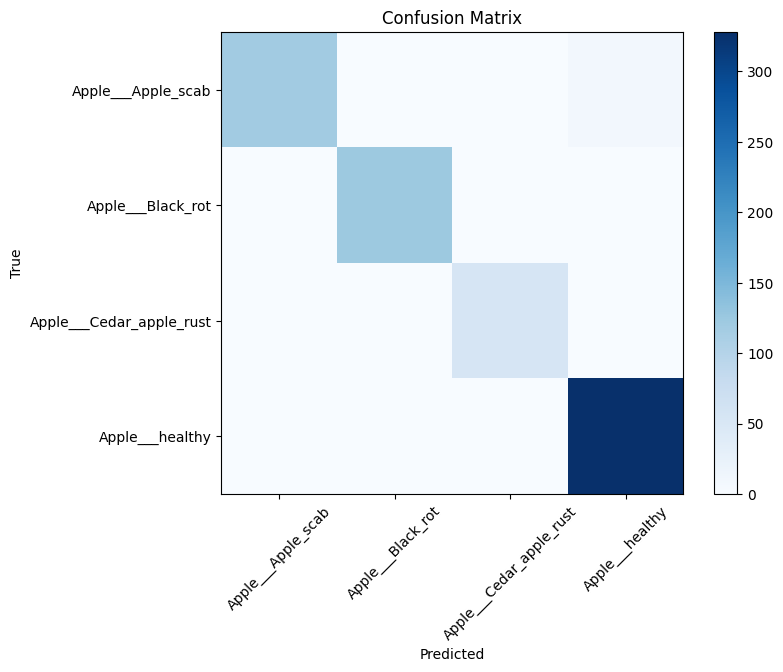

In [30]:
# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [31]:
# Step 7: Function to test the model with input image
from tensorflow.keras.preprocessing import image

def test_single_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize

    prediction = model.predict(img)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(image.load_img(image_path))
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 22ms/step


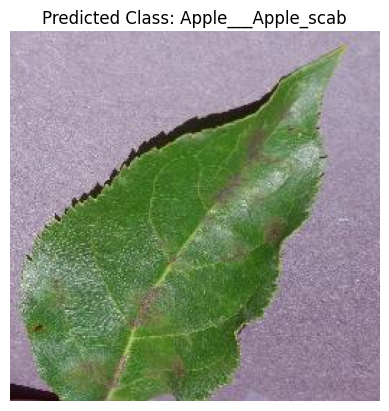

In [34]:
# Example usage:
test_single_image('/content/gdrive/MyDrive/Capstone Project/DATA/data_split/test/Apple___Apple_scab/9082fc1b-6621-48be-9953-50d3de9a6661___FREC_Scab 3065.JPG')